# <span style="color:darkgreen">DATSCIW261 ASSIGNMENT 7</span>
#### MIDS UC Berkeley, Machine Learning at Scale

<b>AUTHOR</b> : Rich Johnson, Charles Maalouf, Rajesh Thallam <br>
<b>EMAIL</b>  : richard.johnson@ischool.berkeley.edu, cmaalouf@berkeley.edu, rajesh.thallam@ischool.berkeley.edu <br>
<b>WEEK</b>   : 9 <br>
<b>DATE</b>   : 27-Oct-15

***

<h2><span style="color:dodgerblue;font:12px">HW7.0</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Shortest path graph distances (toy networks)<b></span><br><br>
<span style="color:CornflowerBlue "> Write MRJob classes to find shortest path graph distances, as described in the lectures. In addition to finding the distances, your code should also output a distance-minimizing path between the source and target. Work locally for this part of the assignment, and use both of the undirected and directed toy networks. To proof you code's function, run the following jobs </span> <br><br>
<span style="color:CornflowerBlue "> - shortest path in the undirected network from node 1 to node 4</span><br>
<span style="color:CornflowerBlue "> - shortest path in the directed network from node 1 to node 5</span><br>
<br>

In [550]:
%%writefile dijkstra.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.emr import EMRJobRunner
from boto.s3.key import Key
import ast
import sys
import boto

class MRDijkstra(MRJob):

    # generator that returns boto.s3.Key names.
    def write_to_s3(bucket, key, string):
        emr = EMRJobRunner()
        c = emr.fs.make_s3_conn()
        b = c.get_bucket(bucket)
        k = Key(b)
        k.key = key
        k.set_contents_from_string(string)
    
    # set command line option to accept start and end node
    def configure_options(self):
        super(MRDijkstra, self).configure_options()

        self.add_passthrough_option('--startnode', default='1', type=str, help='starting node for single source shortest path')
        self.add_passthrough_option('--endnode', default=None, type=str, help='target node to be visited')
        self.add_passthrough_option('--bucket', default=None, type=str, help='bucket to write secondary output')
        self.add_passthrough_option('--runmode', default=None, type=str, help='local or emr')

    def mapper_init(self):
        self.startnode = self.options.startnode

    # emit (node, [edges, distance, path, state]))
    def mapper(self, _, line):
        # parse input
        line = line.strip()
        data = line.split('\t')
        values = data[1].strip('"').split("|")
        
        # init variables
        node = None
        edges = None
        path = list()
        dist = sys.maxint
        state = None
        
        # parse the input for first iteration
        if len(values) >= 1:
            node = data[0].strip('"')
            edges = ast.literal_eval(values[0])
        # parse the input for subsequent iterations 
        if len(values) == 4:
            dist = int(values[1])
            path = ast.literal_eval(values[2])
            state = values[3]
        
        # for first pass set start node to q status
        if state == None and self.startnode == node:
            state = 'q'
            dist = 0
        
        # for frontier nodes emit node with its neighbors
        if state == 'q':
            yield node, (edges, dist, path, 'v')
            path.append(node)

            for n in edges.iterkeys():
                yield n, (None, dist + 1, path, 'q')
        # else emit the current node
        else:
            yield node, (edges, dist, path, state)
            
    def reducer_init(self):
        self.endnode = self.options.endnode
        self.target_reached = -1
        self.target_path = ""
        self.s3bucket = self.options.bucket
        self.runmode = self.options.runmode

    def reducer(self, key, values):
        edges = {}
        dist = list()
        state = list()
        path = list()
        f_state = ''

        for v in values:
            v_edges = v[0]
            v_dist = v[1]
            v_path = v[2]
            v_state = v[3]
            
            if v_state == 'v':
                edges = v_edges
                dist.append(v_dist)
                path = v_path
                state.append(v_state)
                break
            
            dist.append(v_dist)
            state.append(v_state)

            if v_edges != None:
                edges = v_edges
            if v_path != None and len(v_path) > 0:
                path = v_path
                
        Dmin = min(dist)
        
        if 'v' in state:
            f_state = 'v'
            if self.endnode != None and key.strip('"') == self.endnode:
                self.increment_counter('group', 'visited', 0)
                self.target_reached = 1
                self.target_path = str(key) + "\t" + str(edges) + '|' + str(Dmin) + '|' + str(path) + '|' + "F"
        elif 'q' in state:
            f_state = 'q'
            self.increment_counter('group', 'pending', 1)
        else:
            f_state = 'u'
            self.increment_counter('group', 'pending', 1)
            
        yield key, str(edges) + '|' + str(Dmin) + '|' + str(path) + '|' + f_state

    def reducer_final(self):
        if self.target_reached == 1:
            sys.stderr.write('Target reached')
            if self.runmode == 'emr':
                sys.stderr.write(self.target_path)
                s3_key = 'hw7/visited.txt'
                emr = EMRJobRunner()
                c = emr.fs.make_s3_conn()
                b = c.get_bucket(self.s3bucket)
                k = Key(b)
                k.key = s3_key
                k.set_contents_from_string(self.target_path)
                #self.write_to_s3(self.options.bucket, s3_key, self.target_path)
            else:
                yield self.target_path.split('\t')[0], self.target_path.split('\t')[1]
            
        
if __name__ == '__main__':
    MRDijkstra.run()

Overwriting dijkstra.py


In [492]:
%%writefile run_sspp.py
#!/usr/bin/python
from dijkstra import MRDijkstra
import time
import sys
import ast

SOURCE = sys.argv[1]
START_NODE = sys.argv[2]

if len(sys.argv) == 4:
    END_NODE = sys.argv[3]

start_time = time.time()
print "processing file {}".format(SOURCE)

# on local
mr_job = MRDijkstra(args=[SOURCE, '--startnode', START_NODE, '--endnode', END_NODE, '-q', '-r', 'local', '--no-strict-protocol'])

# on EMR
#mr_job = MRDijkstra(args=['s3 path', '-q', '-r', 'emr', #    --output-dir=s3://ucb-mids-mls-rajeshthallam/hw_5_4/distance \'--no-strict-protocol'])
#!./dijkstra.py ./output/word_cooccurrences.txt -q \
#    -r emr \
#    --file ./output/word_cooccurrences.txt \
#    --no-strict-protocol

counter = 0
prev_counters = [{}]

while (1):
    with mr_job.make_runner() as runner: 
        counter += 1
        print "iteration #{}".format(counter)

        runner.run()

        f = open(SOURCE, 'w+')

        for line in runner.stream_output():
            f.writelines(line)
            line = line.split('\t')

            node = line[0].strip('"')
            stripe = line[1].strip('"').split('|')
            edges = stripe[0]
            dist = stripe[1]
            path = stripe[2]
            state = stripe[3].replace('"', "")
            
            #out = "{}\t{}|{}|{}|{}".format(node, edges, dist, path, state)

            if state[0] == 'F' :
                path = ast.literal_eval(path)
                shortest_path = '->'.join(path) + "->" + node
                min_distance = dist
            
        curr_counters = runner.counters()
        visited = curr_counters[0]['group'].get('visited', -1)
        print curr_counters
        if curr_counters == [{}] or curr_counters == prev_counters or visited == 0:
            break
        
        prev_counters = runner.counters()

    f.close()

end_time = time.time()
print "Time taken to find shortest path = {:.2f} seconds".format(end_time - start_time)
print "shortest path in the network from node {} to node {} is {} with distance of {}".format(START_NODE, END_NODE, shortest_path, min_distance)

Overwriting run_sspp.py


In [493]:
!cp ./undirected_toy.txt ./undirected_toy.txt.out
!./run_sspp.py ./undirected_toy.txt.out 1 4

processing file ./undirected_toy.txt.out
iteration #1
No handlers could be found for logger "mrjob.local"
[{'group': {'pending': 4}}]
iteration #2
[{'group': {'pending': 2}}]
iteration #3
[{'group': {'visited': 0}}]
Time taken to find shortest path = 6.92 seconds
shortest path in the network from node 1 to node 4 is 1->5->4 with distance of 2


In [440]:
!cp ./directed_toy.txt ./directed_toy.txt.out
!./run_sspp.py ./directed_toy.txt.out 1 5

processing file ./directed_toy.txt.out
iteration #1
No handlers could be found for logger "mrjob.local"
[{'group': {'pending': 5}}]
iteration #2
[{'group': {'pending': 3}}]
iteration #3
[{'group': {'pending': 1}}]
iteration #4
[{'group': {'visited': 0}}]
Time taken to find shortest path = 8.81 seconds
shortest path in the network from node 1 to node 5 is 1->2->4->5 with distance of 3


In [371]:
!aws s3 cp s3://ucb-mids-mls-networks/synNet/synNet.txt ./synNet.txt.out
!./run_sspp.py ./synNet.txt.out 1 1462

download: s3://ucb-mids-mls-networks/synNet/synNet.txt to ./synNet.txt.out
processing file ./synNet.txt.out
iteration #1
No handlers could be found for logger "mrjob.local"
[{'group': {'pending': 8270}}]
iteration #2
[{'group': {'pending': 8267}}]
iteration #3
[{'group': {'pending': 8265}}]
iteration #4
[{'group': {'pending': 8252}}]
iteration #5
[{'group': {'pending': 8158}}]
iteration #6
[{'group': {'pending': 7698}}]
iteration #7
[{'group': {'visited': 0, 'pending': 6097}}]
Time taken to find shortest path = 23.52 seconds
shortest path in the network from node 1 to node 1462 is 1->2->310->584->902->173->1462 with distance of 6


In [372]:
!aws s3 cp s3://ucb-mids-mls-networks/synNet/synNet.txt ./synNet.txt.out
!./run_sspp.py ./synNet.txt.out 7827 536

download: s3://ucb-mids-mls-networks/synNet/synNet.txt to ./synNet.txt.out
processing file ./synNet.txt.out
iteration #1
No handlers could be found for logger "mrjob.local"
[{'group': {'pending': 8270}}]
iteration #2
[{'group': {'pending': 8265}}]
iteration #3
[{'group': {'pending': 8158}}]
iteration #4
[{'group': {'visited': 0, 'pending': 7583}}]
Time taken to find shortest path = 13.82 seconds
shortest path in the network from node 7827 to node 536 is 7827->4655->631->536 with distance of 3


In [468]:
!./run_sspp.py /home/rt/wrk/w261/hw7/out/2/SOURCE.txt 7827 536

processing file /home/rt/wrk/w261/hw7/out/2/SOURCE.txt
iteration #1
No handlers could be found for logger "mrjob.local"
[{'group': {'pending': 8265}}]
iteration #2
[{'group': {'pending': 8158}}]
iteration #3
[{'group': {'visited': 0, 'pending': 7583}}]
Time taken to find shortest path = 10.00 seconds
shortest path in the network from node 7827 to node 536 is 7827->4655->631->536 with distance of 3


<h2><span style="color:dodgerblue;font:12px">HW7.2</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Shortest path graph distances (NLTK synonyms)<b></span><br><br>
<span style="color:CornflowerBlue "> Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, and apply it to the NLTK synonyms network dataset. Proof your code's function by running the job: <br>- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),<br>
and showing you code's output. Once again, your output should include the path and the distance. </span> <br><br>

In [481]:
%%writefile run_sspp_syn.py
#!/usr/bin/python
from dijkstra import MRDijkstra
import time
import sys
import ast

start_time = time.time()

# load indices file into memory
lookup = { k:v for k, v in (line.split("\t") for line in open('./indices.txt').read().strip().split('\n')) }

SOURCE = sys.argv[1]
START_WORD = sys.argv[2]
START_NODE = lookup[START_WORD]

if len(sys.argv) == 4:
    END_WORD = sys.argv[3]
    END_NODE = lookup[END_WORD]
    
# reverse lookup i.e. give word based on index
lookup = { v:k for k, v in (line.split("\t") for line in open('./indices.txt').read().strip().split('\n')) }
    
print "processing file {}".format(SOURCE)
print "start word {} ({})".format(START_WORD, START_NODE)
print "end word {} ({})".format(END_WORD, END_NODE)
    
# on local
mr_job = MRDijkstra(args=[SOURCE, '--startnode', START_NODE, '--endnode', END_NODE, '-q', '-r', 'local', '--no-strict-protocol'])

# on EMR
#mr_job = MRDijkstra(args=['s3 path', '-q', '-r', 'emr', #    --output-dir=s3://ucb-mids-mls-rajeshthallam/hw_5_4/distance \'--no-strict-protocol'])
#!./dijkstra.py ./output/word_cooccurrences.txt -q \
#    -r emr \
#    --file ./output/word_cooccurrences.txt \
#    --no-strict-protocol

counter = 0
prev_counters = [{}]

while (1):
    with mr_job.make_runner() as runner: 
        counter += 1
        print "iteration #{}".format(counter)

        runner.run()

        f = open(SOURCE, 'w+')

        for line in runner.stream_output():
            f.writelines(line)
            line = line.split('\t')

            node = line[0].strip('"')
            stripe = line[1].strip('"').split('|')
            edges = stripe[0]
            dist = stripe[1]
            path = stripe[2]
            state = stripe[3].replace('"', "")
            
            #out = "{}\t{}|{}|{}|{}".format(node, edges, dist, path, state)

            if state[0] == 'F' :
                path = ast.literal_eval(path)
                words = [ lookup[w] for w in path ]
                end_word = lookup[node]
                shortest_path = ' -> '.join(words) + " -> " + end_word
                min_distance = dist
            
        curr_counters = runner.counters()
        visited = curr_counters[0]['group'].get('visited', -1)
        print curr_counters
        if curr_counters == [{}] or curr_counters == prev_counters or visited == 0:
            break
        
        prev_counters = runner.counters()

    f.close()

end_time = time.time()
print "Time taken to find shortest path = {:.2f} seconds".format(end_time - start_time)
print "shortest path in the synonyms from word '{}' to word '{}' is [ {} ] with distance of {}".format(START_WORD, END_WORD, shortest_path, min_distance)

Overwriting run_sspp_syn.py


In [485]:
#!aws s3 cp s3://ucb-mids-mls-networks/synNet/indices.txt ./indices.txt
!aws s3 cp s3://ucb-mids-mls-networks/synNet/synNet.txt ./synNet.txt.out
!./run_sspp_syn.py ./synNet.txt.out walk Make

download: s3://ucb-mids-mls-networks/synNet/synNet.txt to ./synNet.txt.out
processing file ./synNet.txt.out
start word walk (7827)
end word Make (2246)
iteration #1
No handlers could be found for logger "mrjob.local"
[{'group': {'pending': 8270}}]
iteration #2
[{'group': {'pending': 8265}}]
iteration #3
[{'group': {'pending': 8158}}]
iteration #4
[{'group': {'visited': 0, 'pending': 7583}}]
Time taken to find shortest path = 13.14 seconds
shortest path in the synonyms from word 'walk' to word 'Make' is [ walk -> passes -> draw -> Make ] with distance of 3


In [543]:
%%writefile ReadShortestPath.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import sys

class MRReadShortestPath(MRJob):
    def steps(self):
        return [MRStep(mapper=self.mapper)]

    def mapper(self, _, line):
        # parse input
        line = line.split('\t')

        node = line[0].strip('"')
        stripe = line[1].strip('"').split('|')
        edges = stripe[0]
        dist = stripe[1]
        path = stripe[2]
        state = stripe[3].replace('"', "")
        
        if state[0] == 'F':
            path = ast.literal_eval(path)
            words = [ lookup[w] for w in path ]
            end_word = lookup[node]
            shortest_path = ' -> '.join(words) + " -> " + end_word
            min_distance = dist
            
            yield shortest_path, min_distance
        else:
            pass
        
if __name__ == '__main__':
    MRReadShortestPath.run()

Overwriting ReadShortestPath.py


In [545]:
#!/usr/bin/python
from ReadShortestPath import MRReadShortestPath

# read shortest path
mr_job = MRReadShortestPath(args=[
        's3://ucb-mids-mls-rajeshthallam/hw7/ssps/4/', 
        '-r', 'emr',
        '--num-ec2-instances', '4',
        '--no-strict-protocol'])

f = open('./final_output.txt', 'w+')
with mr_job.make_runner() as runner: 
    runner.run()
    for line in runner.stream_output():
        print line
        f.writelines(line)
f.close()

In [587]:
%%writefile run_sssp_syn_emr.py
#!/usr/bin/python
from dijkstra import MRDijkstra
from ReadShortestPath import MRReadShortestPath
from mrjob.emr import EMRJobRunner
from boto.s3.key import Key
import time
import sys
import ast
import boto

def check_sssp_completed():
    emr = EMRJobRunner()
    key = 'hw7/visited.txt'
    c = emr.fs.make_s3_conn()
    b = c.get_bucket('ucb-mids-mls-rajeshthallam') # substitute your bucket name here
    key_exists = b.get_key(key)
    
    if key_exists == None:
        return "-1"
    else:
        k = Key(b)
        k.key = key
        return k.get_contents_as_string()

def get_output(line):
    line = line.split('\t')

    node = line[0].strip('"')
    stripe = line[1].strip('"').split('|')
    edges = stripe[0]
    dist = stripe[1]
    path = stripe[2]
    state = stripe[3].replace('"', "")
        
    if state[0] == 'F':
        path = ast.literal_eval(path)
        words = [ lookup[w] for w in path ]
        end_word = lookup[node]
        shortest_path = ' -> '.join(words) + " -> " + end_word
        min_distance = str(dist)
            
        return [shortest_path, min_distance]
    
start_time = time.time()

# load indices file into memory
lookup = { k:v for k, v in (line.split("\t") for line in open('./indices.txt').read().strip().split('\n')) }

SOURCE = sys.argv[1] 
START_WORD = sys.argv[2]
START_NODE = lookup[START_WORD]

if len(sys.argv) == 4:
    END_WORD = sys.argv[3]
    END_NODE = lookup[END_WORD]
    
# reverse lookup i.e. give word based on index
lookup = { v:k for k, v in (line.split("\t") for line in open('./indices.txt').read().strip().split('\n')) }
    
print "processing file {}".format(SOURCE)
print "start word {} ({})".format(START_WORD, START_NODE)
print "end word {} ({})".format(END_WORD, END_NODE)

# iterate until shortest path from source to target is found
counter = 0
prev_counters = [{}]

while (1):
    counter += 1
    print "iteration #{}".format(counter)

    if counter == 1:
        s3_source = SOURCE
    else:
        s3_source = 's3://ucb-mids-mls-rajeshthallam/hw7/ssps/' + str(counter-1) + "/"
    
    s3_target = 's3://ucb-mids-mls-rajeshthallam/hw7/ssps/' + str(counter) + "/"
    
    print s3_source
    print s3_target
    
    mr_job = MRDijkstra(args=[s3_source, 
                          '--startnode', START_NODE, 
                          '--endnode', END_NODE, 
                          '--bucket', 'ucb-mids-mls-rajeshthallam',
                          '--runmode', 'emr',
                          '-r', 'emr',
                          '--pool-emr-job-flows',
                          '--max-hours-idle', '1',
                          '--output-dir', s3_target,
                          '--no-output',
                          '--no-strict-protocol'])

    with mr_job.make_runner() as runner: 
        runner.run()
    
    status = check_sssp_completed()
    if status != "-1":
        break
    else:
        print status
        
print get_output(status)
shortest_path, min_distance = get_output(status)

end_time = time.time()
print "Time taken to find shortest path = {:.2f} seconds".format(end_time - start_time)
print "shortest path in the synonyms from word '{}' to word '{}' is [ {} ] with distance of {}".format(START_WORD, END_WORD, shortest_path, min_distance)

Overwriting run_sssp_syn_emr.py


In [586]:
# cleanup
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw7/ssps --recursive
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw7/visited.txt

print "Downloading indices to local"
!aws s3 cp s3://ucb-mids-mls-networks/synNet/indices.txt ./indices.txt
    
# run job
!./run_sssp_syn_emr.py "s3://ucb-mids-mls-networks/synNet/synNet.txt" walk make

A client error (404) occurred when calling the HeadObject operation: Key "hw7/visited.txt" does not exist
Completed 1 part(s) with ... file(s) remaining
download: s3://ucb-mids-mls-networks/synNet/indices.txt to ./indices.txt
processing file s3://ucb-mids-mls-networks/synNet/synNet.txt
start word walk (7827)
end word make (536)
iteration #1
s3://ucb-mids-mls-networks/synNet/synNet.txt
s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/
No handlers could be found for logger "mrjob.util"
-1
iteration #2
s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/
s3://ucb-mids-mls-rajeshthallam/hw7/ssps/2/
-1
iteration #3
s3://ucb-mids-mls-rajeshthallam/hw7/ssps/2/
s3://ucb-mids-mls-rajeshthallam/hw7/ssps/3/
-1
iteration #4
s3://ucb-mids-mls-rajeshthallam/hw7/ssps/3/
s3://ucb-mids-mls-rajeshthallam/hw7/ssps/4/
536	{'215': 1, '3648': 1, '662': 1, '3658': 1, '3656': 1, '3657': 1, '3651': 1, '3652': 1, '3653': 1, '3555': 1, '3554': 1, '6002': 1, '3552': 1, '6000': 1, '6001': 1, '404': 1, '2248': 1, '2249': 1, '4180

In [588]:
%%writefile run_sssp_syn_emr_hw7_4.py
#!/usr/bin/python
from dijkstra import MRDijkstra
from ReadShortestPath import MRReadShortestPath
from mrjob.emr import EMRJobRunner
from boto.s3.key import Key
import time
import sys
import ast
import boto

def check_sssp_completed():
    emr = EMRJobRunner()
    key = 'hw7/visited.txt'
    c = emr.fs.make_s3_conn()
    b = c.get_bucket('ucb-mids-mls-rajeshthallam') # substitute your bucket name here
    key_exists = b.get_key(key)
    
    if key_exists == None:
        return "-1"
    else:
        k = Key(b)
        k.key = key
        return k.get_contents_as_string()

def get_output(line):
    line = line.split('\t')

    node = line[0].strip('"')
    stripe = line[1].strip('"').split('|')
    edges = stripe[0]
    dist = stripe[1]
    path = stripe[2]
    state = stripe[3].replace('"', "")
        
    if state[0] == 'F':
        path = ast.literal_eval(path)
        words = [ lookup[w] for w in path ]
        end_word = lookup[node]
        shortest_path = ' -> '.join(words) + " -> " + end_word
        min_distance = str(dist)
            
        return [shortest_path, min_distance]
    
start_time = time.time()

# load indices file into memory
lookup = { k:v for k, v, v1, v2 in (line.split("\t") for line in open('./indices.txt').read().strip().split('\n')) }

SOURCE = sys.argv[1] 
START_WORD = sys.argv[2]
START_NODE = lookup[START_WORD]

if len(sys.argv) == 4:
    END_WORD = sys.argv[3]
    END_NODE = lookup[END_WORD]
    
# reverse lookup i.e. give word based on index
lookup = { v:k for k, v, v1, v2 in (line.split("\t") for line in open('./indices.txt').read().strip().split('\n')) }
    
print "processing file {}".format(SOURCE)
print "start word {} ({})".format(START_WORD, START_NODE)
print "end word {} ({})".format(END_WORD, END_NODE)

# iterate until shortest path from source to target is found
counter = 0
prev_counters = [{}]

while (1):
    counter += 1
    print "iteration #{}".format(counter)

    if counter == 1:
        s3_source = [
            's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt', 
            's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt'
        ]
    else:
        s3_source = ['s3://ucb-mids-mls-rajeshthallam/hw7/ssps/' + str(counter-1) + "/"]
    
    s3_target = 's3://ucb-mids-mls-rajeshthallam/hw7/ssps/' + str(counter) + "/"
    
    print s3_source
    print s3_target
    
    args = [
        '--startnode', START_NODE, 
        '--endnode', END_NODE, 
        '--bucket', 'ucb-mids-mls-rajeshthallam',
        '--runmode', 'emr',
        '-r', 'emr',
        '--pool-emr-job-flows',
        '--max-hours-idle', '1',
        '--output-dir', s3_target,
        '--no-output',
        '--no-strict-protocol'
    ] + s3_source
    
    mr_job = MRDijkstra(args)

    with mr_job.make_runner() as runner: 
        runner.run()
    
    status = check_sssp_completed()
    if status != "-1":
        break
    else:
        print status
        
print get_output(status)
shortest_path, min_distance = get_output(status)

end_time = time.time()
print "Time taken to find shortest path = {:.2f} seconds".format(end_time - start_time)
print "shortest path in the synonyms from word '{}' to word '{}' is [ {} ] with distance of {}".format(START_WORD, END_WORD, shortest_path, min_distance)

Writing run_sssp_syn_emr_hw7_4.py


In [589]:
# cleanup
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw7/ssps --recursive
!aws s3 rm s3://ucb-mids-mls-rajeshthallam/hw7/visited.txt

# download indices to local
print "Downloading indices to local"
!aws s3 cp s3://ucb-mids-mls-networks/wikipedia/indices.txt ./indices.txt
    
# run job
!./run_sssp_syn_emr_hw7_4.py "s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt" "Ireland" "University of California, Berkeley"

delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/_SUCCESS
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00009
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00006
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00003
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00001
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00000
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00005
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00010
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00004
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00008
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00013
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00011
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00012
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00015
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00014
delete: s3://ucb-mids-mls-rajeshthallam/hw7/ssps/1/part-00007
delete: s3

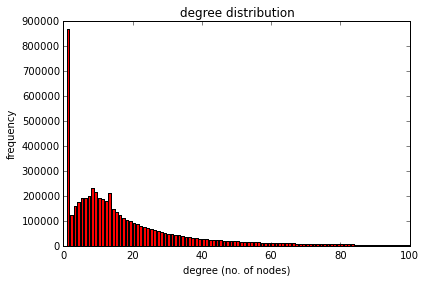

In [592]:
%matplotlib inline
import matplotlib.pyplot as plt

degree_d = {}
for line in open('./degree_distribution.txt').read().strip().split('\n'):
    degree, frequency = line.split('\t')
    degree = int(degree)
    frequency = int(frequency)
    degree_d[degree] = degree_d.get(degree, 0) + frequency

fig, ax = plt.subplots()
distribution = plt.bar(degree_d.keys(), degree_d.values(), color = "r")
plt.ylabel('frequency')
plt.xlabel('degree (no. of nodes)')
plt.xlim([0, 100])
plt.title('degree distribution')

plt.tight_layout()
plt.show()